In [1]:
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DistilBertModel
from torch.utils.data import Dataset,DataLoader

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


#### Import data

In [5]:
raw_data = load_dataset('emotion')

Using custom data configuration default
Reusing dataset emotion (/home/sabber/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
from collections import Counter
print(Counter(raw_data['train']['label']))
print(Counter(raw_data['validation']['label']))
print(Counter(raw_data['test']['label']))

Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})
Counter({1: 704, 0: 550, 3: 275, 4: 212, 2: 178, 5: 81})
Counter({1: 695, 0: 581, 3: 275, 4: 224, 2: 159, 5: 66})


In [7]:
train = raw_data['train'].to_pandas()
validation = raw_data['validation'].to_pandas()
test = raw_data['test'].to_pandas()

In [8]:
train.shape, validation.shape, test.shape

((16000, 2), (2000, 2), (2000, 2))

In [9]:
train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


### One hot encode lables

In [10]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [11]:
train_labels = pd.DataFrame(encoder.fit_transform(train[['label']]).toarray())
validation_labels = pd.DataFrame(encoder.fit_transform(validation[['label']]).toarray())
test_labels = pd.DataFrame(encoder.fit_transform(test[['label']]).toarray())

### Define parameters

In [12]:
## Parameters
LEARNING_RATE:float = 0.0001
EPOCHS:int = 30
BATCH_SIZE:int = 1024
TEXT_MAX_LEN = 16
SHUFFLE:bool = True
NUM_CLASSES:int = train_labels.shape[1]
VALID_DATA_PERCENTAGE:float = 0.2

In [13]:

class EmotionDataset:
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
            
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        inputs = self.tokenizer(text, max_length=self.max_len,
                                        padding="max_length", truncation=True, return_tensors='pt')
        
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [14]:
## Dataset
train_dataset = EmotionDataset(train['text'].tolist(), train_labels.to_numpy(), tokenizer, max_len=TEXT_MAX_LEN)
validation_dataset = EmotionDataset(validation['text'].tolist(), validation_labels.to_numpy(), tokenizer, max_len=TEXT_MAX_LEN)
test_dataset = EmotionDataset(test['text'].tolist(), test_labels.to_numpy(), tokenizer, max_len=TEXT_MAX_LEN)

In [15]:
### Data loader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [16]:
class DistillBeterClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.distillbert = DistilBertModel.from_pretrained('distilbert-base-uncased', return_dict=True)
        self.layer_1 = nn.Linear(768, 128)
        self.layer_2 = nn.Linear(128, 64)
        self.layer_3 = nn.Linear(64, 32)
        self.layer_4 = nn.Linear(32, NUM_CLASSES)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, ids, masks):
        distill_out = self.distillbert(ids.squeeze(), masks.squeeze())
        pooled_output = distill_out[0]
        pooled_output = pooled_output[:, 0]
        
        output = self.relu(self.dropout(pooled_output))
        output = self.relu(self.dropout(self.layer_1(output)))
        output = self.relu(self.dropout(self.layer_2(output)))
        output = self.relu(self.dropout(self.layer_3(output)))
        logits = self.layer_4(output)
        return logits
        

In [17]:
model = DistillBeterClassifier().to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [19]:
def evaluate(dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for bi, d in enumerate(dataloader):
            ids = d["ids"]
            mask = d["mask"]
            targets = d["labels"]
            
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            outputs = model(ids=ids, masks=mask)

            loss = criterion(outputs, targets)
            total_loss += loss.item()
        
        return total_loss / len(dataloader)

In [20]:

def train(dataloader):
    model.train()
    total_loss = 0.0
    for bi, d in enumerate(dataloader):
        
        ids = d["ids"]
        mask = d["mask"]
        targets = d["labels"]
        
        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(ids=ids, masks=mask)

        loss = criterion(outputs, targets.float())
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        # scheduler.step()
        
    return total_loss / len(dataloader)

In [21]:
### final training
train_loss = []
validation_loss = []
for epoch in range(1, EPOCHS +1):
    train_loss.append(train(train_dataloader))
    validation_loss.append(evaluate(validation_dataloader))
    print(
        f'Epoch: {epoch} | Train Loss: {train_loss[epoch-1]:.4f} | Valid loss: {validation_loss[epoch-1]:.4f}'
    )

/tmp/ipykernel_3129974/3639426345.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
/tmp/ipykernel_3129974/3639426345.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),


Epoch: 1 | Train Loss: 0.6634 | Valid loss: 0.6344
Epoch: 2 | Train Loss: 0.6237 | Valid loss: 0.5941
Epoch: 3 | Train Loss: 0.5828 | Valid loss: 0.5404
Epoch: 4 | Train Loss: 0.5378 | Valid loss: 0.4823
Epoch: 5 | Train Loss: 0.4947 | Valid loss: 0.4326
Epoch: 6 | Train Loss: 0.4575 | Valid loss: 0.3935
Epoch: 7 | Train Loss: 0.4215 | Valid loss: 0.3606
Epoch: 8 | Train Loss: 0.3856 | Valid loss: 0.3342
Epoch: 9 | Train Loss: 0.3537 | Valid loss: 0.3071
Epoch: 10 | Train Loss: 0.3202 | Valid loss: 0.2874
Epoch: 11 | Train Loss: 0.2902 | Valid loss: 0.2674
Epoch: 12 | Train Loss: 0.2629 | Valid loss: 0.2596
Epoch: 13 | Train Loss: 0.2350 | Valid loss: 0.2486
Epoch: 14 | Train Loss: 0.2144 | Valid loss: 0.2482
Epoch: 15 | Train Loss: 0.1974 | Valid loss: 0.2497
Epoch: 16 | Train Loss: 0.1827 | Valid loss: 0.2487
Epoch: 17 | Train Loss: 0.1668 | Valid loss: 0.2581
Epoch: 18 | Train Loss: 0.1513 | Valid loss: 0.2513
Epoch: 19 | Train Loss: 0.1409 | Valid loss: 0.2753
Epoch: 20 | Train Los

KeyboardInterrupt: 

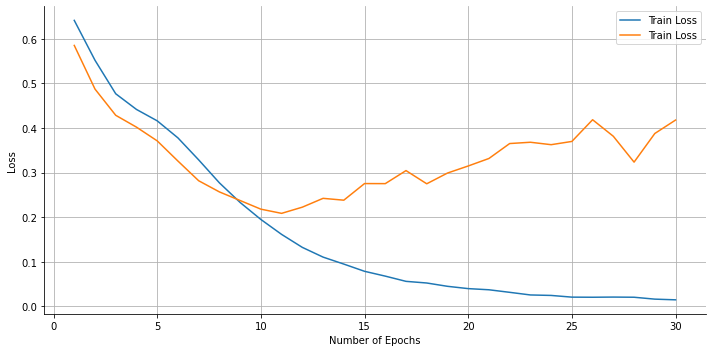

In [ ]:
epochs = np.arange(1, EPOCHS +1)
plt.figure(figsize=(10,5))
sns.lineplot(x = epochs, y = train_loss, label = "Train Loss")
sns.lineplot(x = epochs, y = validation_loss, label = "Train Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.grid()
sns.despine()
plt.tight_layout()

In [ ]:
def get_emotion(text):
  input_ids = tokenizer.encode(text, return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length = TEXT_MAX_LEN)
  
  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label